In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy import stats
import tensorflow as tf
import math
import random

%matplotlib inline
plt.style.use('ggplot')

In [2]:
normalization_coef = 9
batch_size = 10
kernel_size = 30
depth = 20
num_hidden = 100
num_channels = 2

learning_rate = 0.0001
training_epochs = 3

filter_value = 20

In [3]:
def convolve1d(signal, length):
    ir = np.ones(length)/length
    #return np.convolve(y, ir, mode='same')
    
    output = np.zeros_like(signal)

    for i in range(len(signal)):
        for j in range(len(ir)):
            if i - j < 0: continue
            output[i] += signal[i - j] * ir[j]
            
    return output

def filterRecord(record, filter_value):
    x = convolve1d(record[:,0], filter_value)
    y = convolve1d(record[:,1], filter_value)
    return np.dstack([x,y])[0]


def readFileData(file):
    column_names = ['timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file, header = None, names = column_names)
    
    x = data["x-axis"]
    y = data["y-axis"]
    z = data["z-axis"]
    
    return np.dstack([x,y])[0]

def readData(directory):
    records = []
    labels = np.empty((0))
    
    allFiles = glob.glob(directory + "/*.log")
    for file in allFiles:
        fileName = os.path.basename(file)
        (name, ext) = os.path.splitext(fileName)
        parts = name.split("_")
        if (len(parts) == 2):
            label = parts[0]
            fileData = readFileData(file)
            
            records.append(fileData)
            labels = np.append(labels, label)
            
    return (records, labels)

def getRecordsMaxLength(records):
    maxLen = 0
    for record in records:
        if (len(record) > maxLen):
            maxLen = len(record)
        
    return maxLen

def extendRecordsLen(records, length):
    ret = np.empty((0, length, 2))
    
    for index in range(len(records)):
        record = records[index]
        if (len(record) < length):
            record = np.pad(record, ((0, length - len(record)), (0,0)), mode='constant', constant_values=0)
            
        if filter_value != 0: 
            record = filterRecord(record, filter_value)
            
        ret = np.append(ret, [record], axis=0)
    
    return ret

def augmentRecord(record, shift):
    e = np.empty_like(record)
    if shift >= 0:
        e[:shift] = 0
        e[shift:] = record[:-shift]
    else:
        e[shift:] = 0
        e[:shift] = record[-shift:]
    return e

def augmentData(records, labels, length):
    aug_records = np.empty((0, length, 2))
    aug_labels = np.empty((0))

    for index in range(len(records)):
        record = records[index]
        label = labels[index]
        
        aug_records = np.append(aug_records, [record], axis=0)
        aug_labels = np.append(aug_labels, label)
        
        shift = 3 # 3..21 step 3
        while shift <= 21:
            aug_records = np.append(aug_records, [augmentRecord(record, shift)], axis=0)
            aug_labels = np.append(aug_labels, label)
            
            aug_records = np.append(aug_records, [augmentRecord(record, -shift)], axis=0)
            aug_labels = np.append(aug_labels, label)

            shift += 3

    return (aug_records, aug_labels)
        

def normalizeRecords(records):
    return records / normalization_coef

def plotRecord(record, label):
    plt.plot(record)
    plt.ylabel(label)
    plt.show()
    
def plotRecords(record1, record2):
    fig = plt.figure(figsize=(20, 10))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(record1)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(record2)

    plt.show()

In [4]:
(records, labels) = readData("data")
rec_len = getRecordsMaxLength(records)
print("Record length is %d" % rec_len)

records = extendRecordsLen(records, rec_len)
records = normalizeRecords(records)
(records, labels) = augmentData(records, labels, rec_len)

labelsBin = np.asarray(pd.get_dummies(labels), dtype = np.int8)

print("Samples: %d" % len(records))

Record length is 128
Samples: 15000


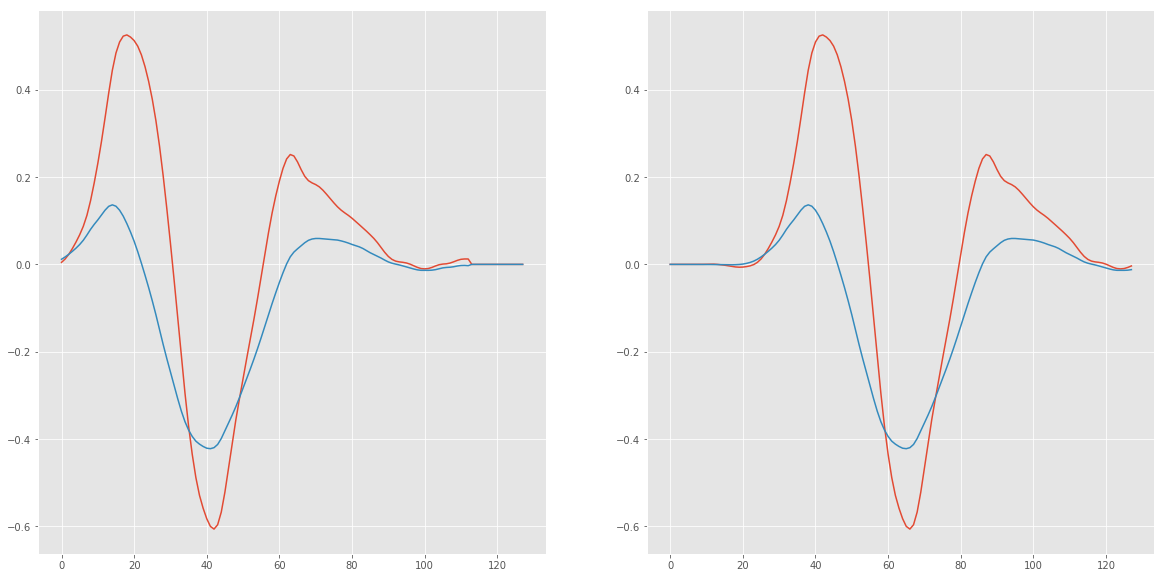

In [5]:
plotRecords(records[10], records[5])

In [6]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [7]:
train_test_split = np.random.rand(len(records)) < 0.70
train_x = records[train_test_split]
train_y = labelsBin[train_test_split]
test_x = records[~train_test_split]
test_y = labelsBin[~train_test_split]


In [8]:
num_labels = len(set(labels))
total_batches = train_x.shape[0] // batch_size

In [9]:
X = tf.placeholder(tf.float32, shape=[None, rec_len, num_channels], name="x_input")
X_reshaped = tf.reshape(X, [-1, 1, rec_len, num_channels])
Y = tf.placeholder(tf.float32, shape=[None, num_labels])

c = apply_depthwise_conv(X_reshaped, kernel_size, num_channels, depth)
p = apply_max_pool(c, 20, 2)
c = apply_depthwise_conv(p, 6, depth*num_channels, depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1), f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases, name="labels_output")

In [10]:
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
cost_history = np.empty(shape=[1],dtype=float)

saver = tf.train.Saver()

with tf.Session() as session:
    #tf.global_variables_initializer().run()
    session.run(tf.global_variables_initializer())
    # save the graph
    tf.train.write_graph(session.graph_def, '.', 'session.pb', False)
    
    for epoch in range(training_epochs):
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print ("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ", session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print ("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))
    saver.save(session, './session.ckpt')

Epoch:  0  Training Loss:  0.0598981  Training Accuracy:  0.996759
Epoch:  1  Training Loss:  0.00727507  Training Accuracy:  0.999237
Epoch:  2  Training Loss:  0.00197791  Training Accuracy:  0.999714
Testing Accuracy: 0.999778
